# UNIT 11 대중교통 데이터 시각화하기  
수도권 대중교통 데이터는 국가기관이 아닌 [티머니 홈페이지](https://www.t-money.co.kr/)에서 제공한다.  
이용 안내 → 대중교통 통계자료 → 첨부파일 다운로드

해당 데이터는 네 가지 탭으로 나누어져 있다. 데이터 안의 콤마(,)와 작업일시 열을 삭제한 다음 csv 저장한다.
* 버스정류장별 이용현황  
    - 사용월, 노선ID, 노선번호, 노선별, 버스정류장ID, 버스정류장명, 승차승객수, 하차승객수
* 지하철 노선별 역별 이용현황  
    - 사용월, 호선명, 역ID, 지하철역, 승차승객수, 하차승객수  
* 지하철 유무임별 이용현황 → subwayfee.csv  
    - 사용월, 호선명, 역ID, 지하철역, 유임승차, 유임하차, 무임승차, 무임하차  
* 지하철 시간대별 이용현황 → subwaytime.csv  
    - 사용월, 호선명, 역ID, 지하철역, 시간대(1시간 간격)(승차, 하차)  

## 유임 승차 비율이 가장 높은 역은 어디일까?  

유임 승차 비율이 가장 높은 역을 알기 위해서는 유임 승차 비율을 정의해야 한다. 간단하게 아래와 같이 정해보자.  
```rate = 유임 승차 인원 / 무임 승차 인원```  
이렇게 정의한다면 어떤 문제가 발생할까? 무임 승차 인원이 0인 데이터의 경우 에러가 발생할 것이다. 다시 아래와 같이 정해보자.  
```rate = 유임 승차 인원 / (유임 승차 인원 + 무임 승차 인원)```  

In [5]:
# 유임 승차 비율이 가장 높은 역 찾기
import csv
f = open('subwayfee.csv', encoding='UTF8')
data = csv.reader(f)
next(data)

mx = 0
rate = 0
mx_station = ''

for row in data:
    for i in range(4, 8):  # 문자열 데이터 정수화
        row[i] = int(row[i])
    if row[6] != 0 and (row[4]+row[6]) > 100000:  # 무임 승차 인원이 0이고, 전체 승차 인원이 10만 명 이상인 건에 대하여
        rate = row[4] / (row[4]+row[6])
        if rate > mx:
            mx = rate
            mx_station = row[3] + ' ' + row[1]  # 예) 서울역 1호선
print(mx_station, round(mx*100, 2))

홍대입구 2호선 95.34


In [7]:
# 유무임 승하차 인원이 가장 많은 역은 어디일까
import csv
f = open('subwayfee.csv', encoding='UTF8')
data = csv.reader(f)
next(data)

mx = [0] * 4
mx_station = [''] * 4

for row in data:
    for i in range(4, 8):
        row[i] = int(row[i])
        if row[i] > mx[i-4]:
            mx[i-4] = row[i]
            mx_station[i-4] = row[3] + ' ' + row[1]
for i in range(4):
    print(mx_station[i], mx[i])

강남 2호선 3153418
강남 2호선 3210437
종로3가 1호선 387062
제기동 1호선 400607


# 모든 역의 유무임 승하차 비율은 어떻게 될까
데이터가 있는 모든 역에 대한 유무임 승하차 비율을 파이 차트로 표현해보자. (교재에는 모든 역에 대해 질문하나, 실제 실행하기에는 양이 많으므로 사용자가 입력 받은 역에 대하여만 수행할 수 있도록 바꾸었다.)

궁금한 역을 입력해주세요 : 강남


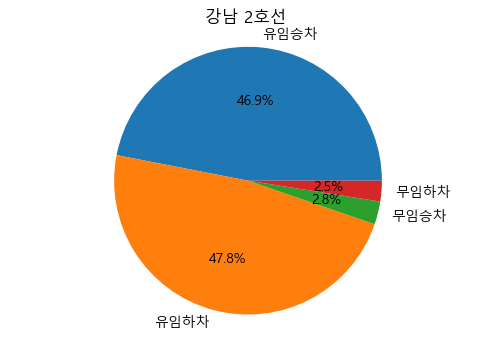

In [15]:
import csv
import matplotlib.pyplot as plt

f = open('subwayfee.csv', encoding='UTF8')
data = csv.reader(f)
next(data)
label = ['유임승차', '유임하차', '무임승차', '무임하차']
result = []

station = input('궁금한 역을 입력해주세요 : ')
line = []
for row in data:
    if row[3] == station:
        value = [0] * 4
        for i in range(4,8):
            value[i-4] = int(row[i])
        result.append(value)
        line.append(row[1])
            
for i in range(len(result)):
    plt.figure(dpi=100)
    plt.rc('font', family='Malgun Gothic')
    plt.title(station+' '+line[i])
    plt.pie(result[i], labels=['유임승차', '유임하차', '무임승차', '무임하차'], autopct='%.1f%%')
    plt.axis('equal')
    plt.show()

# UNIT 12 지하철 시간대별 데이터 시각화하기  
subwaytime.csv를 활용하여 출근시간대 사람들이 가장 많이 타고 내리는 역은 어디인지 확인해보자.  

몇 시의 승하차 데이터가 궁금하세요? : 23
승차 인원이 가장 많은 역 강남(2호선) 145504
하차 인원이 가장 많은 역 신설동(우이신설선) 712


C:\Users\sclab\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


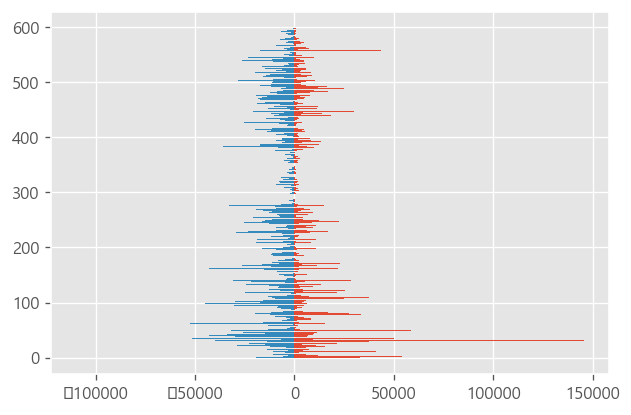

In [53]:
# 지하철 시간대별 승하차 데이터를 수평막대그래프로 나타내기
import csv
f = open('subwaytime.csv', encoding='UTF8')
data = csv.reader(f)
next(data)
next(data)
mx_in = 0
mx_station_in = ''
mx_out = 0
mx_station_out = ''
result_in = []
result_out = []
t = int(input('몇 시의 승하차 데이터가 궁금하세요? : '))

for row in data:
    row[4:] = map(int, row[4:])  # for i in range(4,len(row)+1): row[i] = int(row[i])
    s_in = row[4+(t-4)*2]
    s_out = -row[5+(t-4)*2]
    result_in.append(s_in)
    result_out.append(s_out)
    if s_in > mx_in:
        mx_in = s_in
        mx_station_in = row[3]+'('+row[1]+')'
    if s_out < mx_out:
        mx_out = -s_out
        mx_station_out = row[3]+'('+row[1]+')'
print('승차 인원이 가장 많은 역', mx_station_in, mx_in)
print('하차 인원이 가장 많은 역', mx_station_out, mx_out)
        
import matplotlib.pyplot as plt
plt.figure(dpi=120)
plt.style.use('ggplot')
plt.barh(range(len(result_in)), result_in)
plt.barh(range(len(result_out)), result_out)
plt.show()

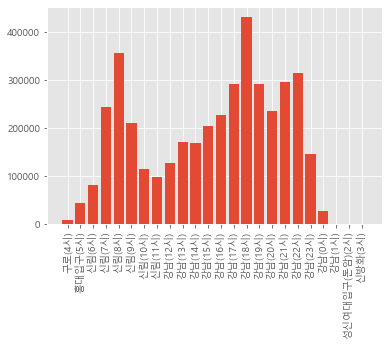

In [52]:
# 시간대별로 사람들이 가장 많이 타는 역은 어디일까
import csv
data = csv.reader(open('subwaytime.csv', encoding='UTF8'))
next(data)
next(data)
mx = [0] * 24
mx_station = [''] *24

for row in data:
    row[4:] = map(int, row[4:])
    for t in range(24):
        a = row[4+t*2]
        if a > mx[t]: 
            mx[t] = a
            mx_station[t] = row[3]+'('+str((t+4)%24)+'시)'

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.bar(range(24), mx)
plt.xticks(range(24), mx_station, rotation=90)
plt.show()

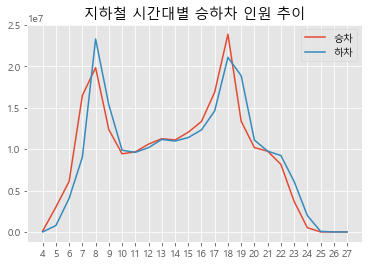

In [54]:
# 시간대별 승하차 인원 추이를 나타내자
import csv
data = csv.reader(open('subwaytime.csv', encoding='UTF8'))
next(data)
next(data)
s_in = [0] * 24
s_out = [0] *24

for row in data:
    row[4:] = map(int, row[4:])
    for t in range(24):
        s_in[t] += row[4+t*2]
        s_out[t] += row[5+t*2]

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.title('지하철 시간대별 승하차 인원 추이')
plt.plot(s_in, label='승차')
plt.plot(s_out, label='하차')
plt.legend()
plt.xticks(range(24), range(4, 28))
plt.show()